In [58]:
import qutip as qt
from qutip.qip.operations import rx
import numpy as np

$|\psi\rangle = e^{-i\phi/2}\cos(\theta/2)|0\rangle + e^{i\phi/2}\sin(\theta/2)|1\rangle$

In [125]:
def to_spherical(state):
    r0 = np.abs(state[0])
    ϕ0 = np.angle(state[0])
    r1 = np.abs(state[1])
    ϕ1 = np.angle(state[1])
    r = np.sqrt(r0 ** 2 + r1 ** 2)
    θ = 2 * np.arccos(r0 / r)
    ϕ = ϕ1 - ϕ0
    return [r, θ, ϕ]

def to_cartesian(polar):
    r = polar[0]
    θ = polar[1]
    ϕ = polar[2]
    x = r * np.sin(θ) * np.cos(ϕ)
    y = r * np.sin(θ) * np.sin(ϕ)
    z = r * np.cos(θ)
    return [x, y, z]

In [232]:
# SO(3) rotation matrix contains a total of three parameters theta,  phi, delta
def rn(state, theta, phi, delta):
    rn_mat = qutip.Qobj(
        [[np.cos(delta/2) - (0+1j)*np.cos(theta)*np.sin(delta/2),
          -(0+1j)*np.exp(-(0+1j)*phi)*np.sin(delta/2)*np.sin(theta)],
         [-(0+1j)*np.exp((0+1j)*phi)*np.sin(delta/2)*np.sin(theta),
          np.cos(delta/2) + (0+1j)*np.cos(theta)*np.sin(delta/2)]]
        )
    r_state = (rn_mat*state)*(rn_mat*state).dag()
    return(r_state)

def rn2(state, θ, ϕ):
    #sin θ cos ϕ σ1 + sin θ sin ϕ σ2 + cos θ σ3
    return (np.sin(θ)*np.cos(ϕ)*qt.sigmax() + np.sin(θ)*np.sin(ϕ)*qt.sigmay() + np.cos(θ)*qt.sigmaz()) * state

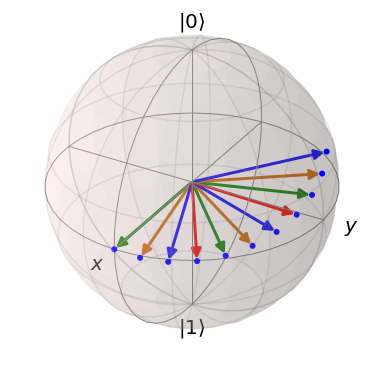

In [228]:
b = qt.Bloch()
b.clear()
b.make_sphere()

states = []
points = []

# [q> = alpha*[0> + beta*[1> = alpha*(1,0) + beta*(0,1)
alpha = 1/np.sqrt(2)
beta = 1/np.sqrt(2)
s = np.array([alpha,beta])
state = qt.Qobj(s)
states.append(state)

Ψ = [complex(alpha, 0), complex(beta, 0)]
polar = to_spherical(Ψ)
pnt = to_cartesian(polar)
points.append(pnt)

rotated = state
for i in range(0,10):
    rotated = rn(rotated, 0.4, 0.3, 0.2)
    pnt = [(qt.sigmax()*rotated).tr(), (qt.sigmay()*rotated).tr(), (qt.sigmaz()*rotated).tr()]
    states.append(rotated)
    points.append(pnt)

b.add_states(states)
np_points = np.array(points)
b.add_points([np_points[:,0], np_points[:,1], np_points[:,2]])
b.show()

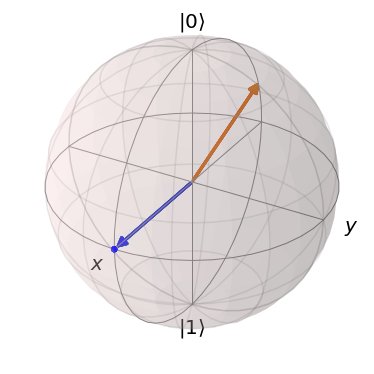

In [236]:
b = qt.Bloch()
b.clear()
b.make_sphere()

states = []
points = []

# [q> = alpha*[0> + beta*[1> = alpha*(1,0) + beta*(0,1)
alpha = 1/np.sqrt(2)
beta = 1/np.sqrt(2)
s = np.array([alpha,beta])
state = qt.Qobj(s)
states.append(state)

Ψ = [complex(alpha, 0), complex(beta, 0)]
polar = to_spherical(Ψ)
pnt = to_cartesian(polar)
points.append(pnt)

rotated = state
for i in range(0,10):
    rotated = rn2(rotated, 0.2, 0.3)
    states.append(rotated)

    #polar = to_spherical(rotated)
    #pnt = to_cartesian(polar)    
    points.append(pnt)

b.add_states(states)

np_points = np.array(points)
b.add_points([np_points[:,0], np_points[:,1], np_points[:,2]])
b.show()